# Attribute Importance for Concept Drift - Primary and Secondary Drift Detection in one dataset

This notebook allows to detect primary and related secondary driftpoints according to the master thesis' framework.

The user specifies a file path for the dataset to analyze and builds the primary as well as secondary drift detectors.

Outputs are graphs as well as drift point lists.

## Setup
### Imports

In [1]:
# imports
import helper
from pm4py.objects.log.importer.xes import importer as xes_importer

from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import population_comparison
from processdrift.framework import windowing
from processdrift.framework import change_point_extraction


import math
import pandas as pd

### Data settings and event log loading

In [2]:
# data settings
data_file_path = 'data/synthetic/attribute_drift/sudden_3_attribute_values/10000/cf10k_0bbd4c9b-97ca-4594-ad55-32d3686e7756.xes' # + 'data\\synthetic\\maardji et al 2013_xes_attributes\\logs\\cb\\cb2.5k.xes' # 

# load event log
event_log = xes_importer.apply(data_file_path)

c:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 10000/10000 [00:08<00:00, 1118.77it/s]


### Configure Primary Drift Detector

In [3]:
# alternative 1: ProDrift Drift detector
primary_process_drift_detector = drift_detection.ProDriftDD(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
                                                                        drift_detection_mechanism='runs',
                                                                        window_size=200,
                                                                        window_mode='adaptive',
                                                                        detect_gradual_as_well=False)

In [4]:
# alternative 2: Configure custom drift detector
# the user can select 
# - a primary feature extractor, specifying which primary axis feature to use
# - a window generator (fixed size or adaptive) incl. the window sizes and further settings
# - a population comparer
# - a threshold for detecting the change points

primary_window_size = 200
primary_slide_by = 10
primary_feature_extractor = feature_extraction.RunsFE()
primary_window_generator = windowing.FixedWG(window_size=primary_window_size, slide_by=primary_slide_by)
primary_population_comparer = population_comparison.GTestPC(0)

primary_threshold = 0.05
primary_phi = math.ceil(primary_window_size / primary_slide_by * 0.5)
primary_rho = 3
print(f"primary_phi={primary_phi}, primary_rho={primary_rho}")

primary_change_point_extractor = change_point_extraction.PhiFilterCPE(primary_threshold, primary_phi, primary_rho)

primary_process_drift_detector = drift_detection.HypothesisTestDD(primary_feature_extractor, 
                                                               primary_window_generator,
                                                               primary_population_comparer, 
                                                               change_point_extractor=primary_change_point_extractor)

primary_phi=10, primary_rho=3


In [5]:
# alternative 3: drift detector true known
# primary_process_drift_detector = drift_detection.TrueKnownDD(helper.get_change_points_maardji_et_al_2013(len(event_log)))

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [6]:
secondary_window_size = 200
secondary_slide_by = 10
secondary_window_generator = windowing.FixedWG(secondary_window_size, slide_by=secondary_slide_by)
secondary_threshold = 0.05
secondary_max_distance = 300

secondary_phi = math.ceil(secondary_window_size / secondary_slide_by / 2)
secondary_rho = 1
print(f"secondary_phi={secondary_phi}, secondary_rho={secondary_rho}")

secondary_change_point_extractor = change_point_extraction.PhiFilterCPE(secondary_threshold, secondary_phi, secondary_rho)

attribute_level_types = helper.get_attributes_and_types_for_synthetic_data()

secondary_drift_detectors = drift_detection.get_attribute_drift_detectors(attribute_level_types,
                                                                         secondary_window_generator, 
                                                                         change_point_extractor=secondary_change_point_extractor)

secondary_phi=10, secondary_rho=1


## Run the Change Point Explainer

In [7]:
# create the change point explainer
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

# get the change point explanations
possible_drift_explanations = drift_explainer.get_possible_drift_explanations(event_log, max_distance=secondary_max_distance)

In [8]:
# show the possible change point explanations
possible_drift_explanations.to_table()

,Primary Change Point,Detector,Secondary Change Point,Lag
0,1029,trace: relevant_attribute_01,1009,-20
1,2029,trace: relevant_attribute_02,2029,0
2,3019,trace: relevant_attribute_03,3059,40
3,4049,trace: relevant_attribute_04,4019,-30
4,4049,trace: relevant_attribute_03,3969,-80
5,4049,trace: irrelevant_attribute_04,3759,-290
6,5009,trace: relevant_attribute_05,5029,20
7,8049,trace: irrelevant_attribute_02,8059,10
8,8049,trace: irrelevant_attribute_02,7819,-230
9,9019,trace: irrelevant_attribute_01,9199,180


<AxesSubplot:>

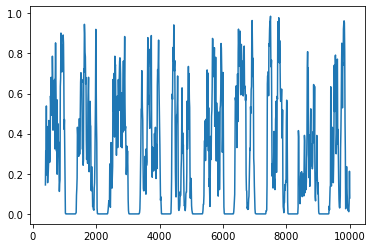

In [9]:
possible_drift_explanations.primary_dd_result.change_series.plot()

In [10]:
# todo delete
import matplotlib.pyplot as plt
from matplotlib import lines

def plot_drift_detection_result(drift_detection_result, primary_change_points=None, threshold=None, secondary_change_points=None, start=None, end=None, ylabel='p-value', offset_legend = -0.3):

    plt.figure()

    # get start and end of change series if desired
    selected_change_series = drift_detection_result.change_series
    if start is not None and end is not None:
        selected_change_series = selected_change_series.loc[start:end]
    elif start is not None and end is None:
        selected_change_series = selected_change_series.loc[start:]
    elif start is None and end is not None:
        selected_change_series = selected_change_series.loc[:end]

    print(selected_change_series)

    secondary_change_line = plt.plot(selected_change_series, color='blue', 
                        marker=".", linewidth=0.75, markersize=1,
                        label=f"p-value")

    # plot the primary change points if some where defined
    if primary_change_points is not None:
        # plot the change points by a red line
        for pcp in primary_change_points:
            plt.axvline(x=pcp, color='red', linewidth=1)

    # plot the secondary change points if some where defined
    if secondary_change_points is not None:
        # plot the secondary change points with crosses
        x = secondary_change_points
        # check if there were secondary change points
        if x is not None:
            y = list(selected_change_series.loc[secondary_change_points])
            plt.scatter(x=x, 
                y=y,
                marker='x',
                color='black'
            )
    
    # plot the threshold as a grey line
    if threshold is not None:
        plt.axhline(y=threshold, color='grey', linewidth=1)

    plt.ylabel(ylabel)
    plt.xlabel('traces')
    plt.title(f'{drift_detection_result.name}')

    plt.ylim(0, 1)
    plt.xlim(min(selected_change_series.index), max(selected_change_series.index))

    # create the legend
    legend_elements = []
    if primary_change_points is not None:
        legend_elements.append(lines.Line2D([0], [0], color='red', linestyle='solid', label='Primary Change Points'))
    
    legend_elements.append(lines.Line2D([0], [0], color='blue', marker=".", linewidth=0.75, markersize=1, label='Secondary Change Series'))

    if threshold is not None:
        legend_elements.append(lines.Line2D([0], [0], color='grey', linewidth=1, label=f'Threshold'))

    if secondary_change_points is not None:
        legend_elements.append(lines.Line2D([0], [0], color='black', marker='x', linestyle='None', label=f'Detected Secondary Change Points'))

    plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, offset_legend))

809     0.477304
819     0.600509
829     0.531914
839     0.774767
849     0.681261
859     0.939452
869     0.955654
879     0.449749
889     0.681977
899     0.681290
909     0.661515
919     0.646031
929     0.448308
939     0.511340
949     0.399009
959     0.390360
969     0.388548
979     0.405991
989     0.346612
999     0.293625
1009    0.257645
1019    0.214673
1029    0.467956
1039    0.769239
1049    0.957310
1059    0.977626
1069    0.686040
1079    0.175825
1089    0.093358
1099    0.181682
1109    0.398169
1119    0.449408
1129    0.448357
1139    0.260567
1149    0.077630
1159    0.049638
1169    0.061815
1179    0.040937
1189    0.014041
1199    0.044817
dtype: float64


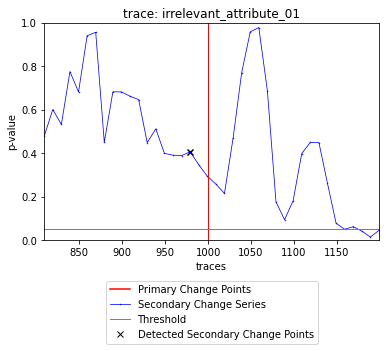

In [11]:
plot_drift_detection_result(possible_drift_explanations.secondary_dd_result_dictionary['trace: irrelevant_attribute_01'], primary_change_points=[1000, 2000], threshold=0.05, secondary_change_points = [979], start=800, end=1200, offset_legend=-0.5)

809     0.477304
819     0.600509
829     0.531914
839     0.774767
849     0.681261
859     0.939452
869     0.955654
879     0.449749
889     0.681977
899     0.681290
909     0.661515
919     0.646031
929     0.448308
939     0.511340
949     0.399009
959     0.390360
969     0.388548
979     0.405991
989     0.346612
999     0.293625
1009    0.257645
1019    0.214673
1029    0.467956
1039    0.769239
1049    0.957310
1059    0.977626
1069    0.686040
1079    0.175825
1089    0.093358
1099    0.181682
1109    0.398169
1119    0.449408
1129    0.448357
1139    0.260567
1149    0.077630
1159    0.049638
1169    0.061815
1179    0.040937
1189    0.014041
1199    0.044817
dtype: float64


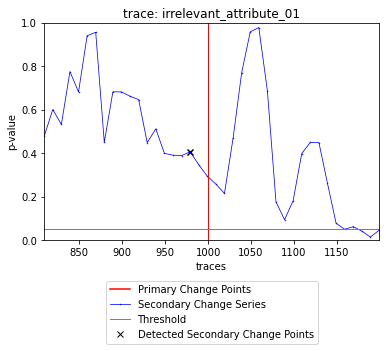

In [13]:
possible_drift_explanations.secondary_dd_result_dictionary['trace: irrelevant_attribute_01'].plot(primary_change_points=[1000, 2000], threshold=0.05, secondary_change_points = [979], start=800, end=1200, offset_legend=-0.5)

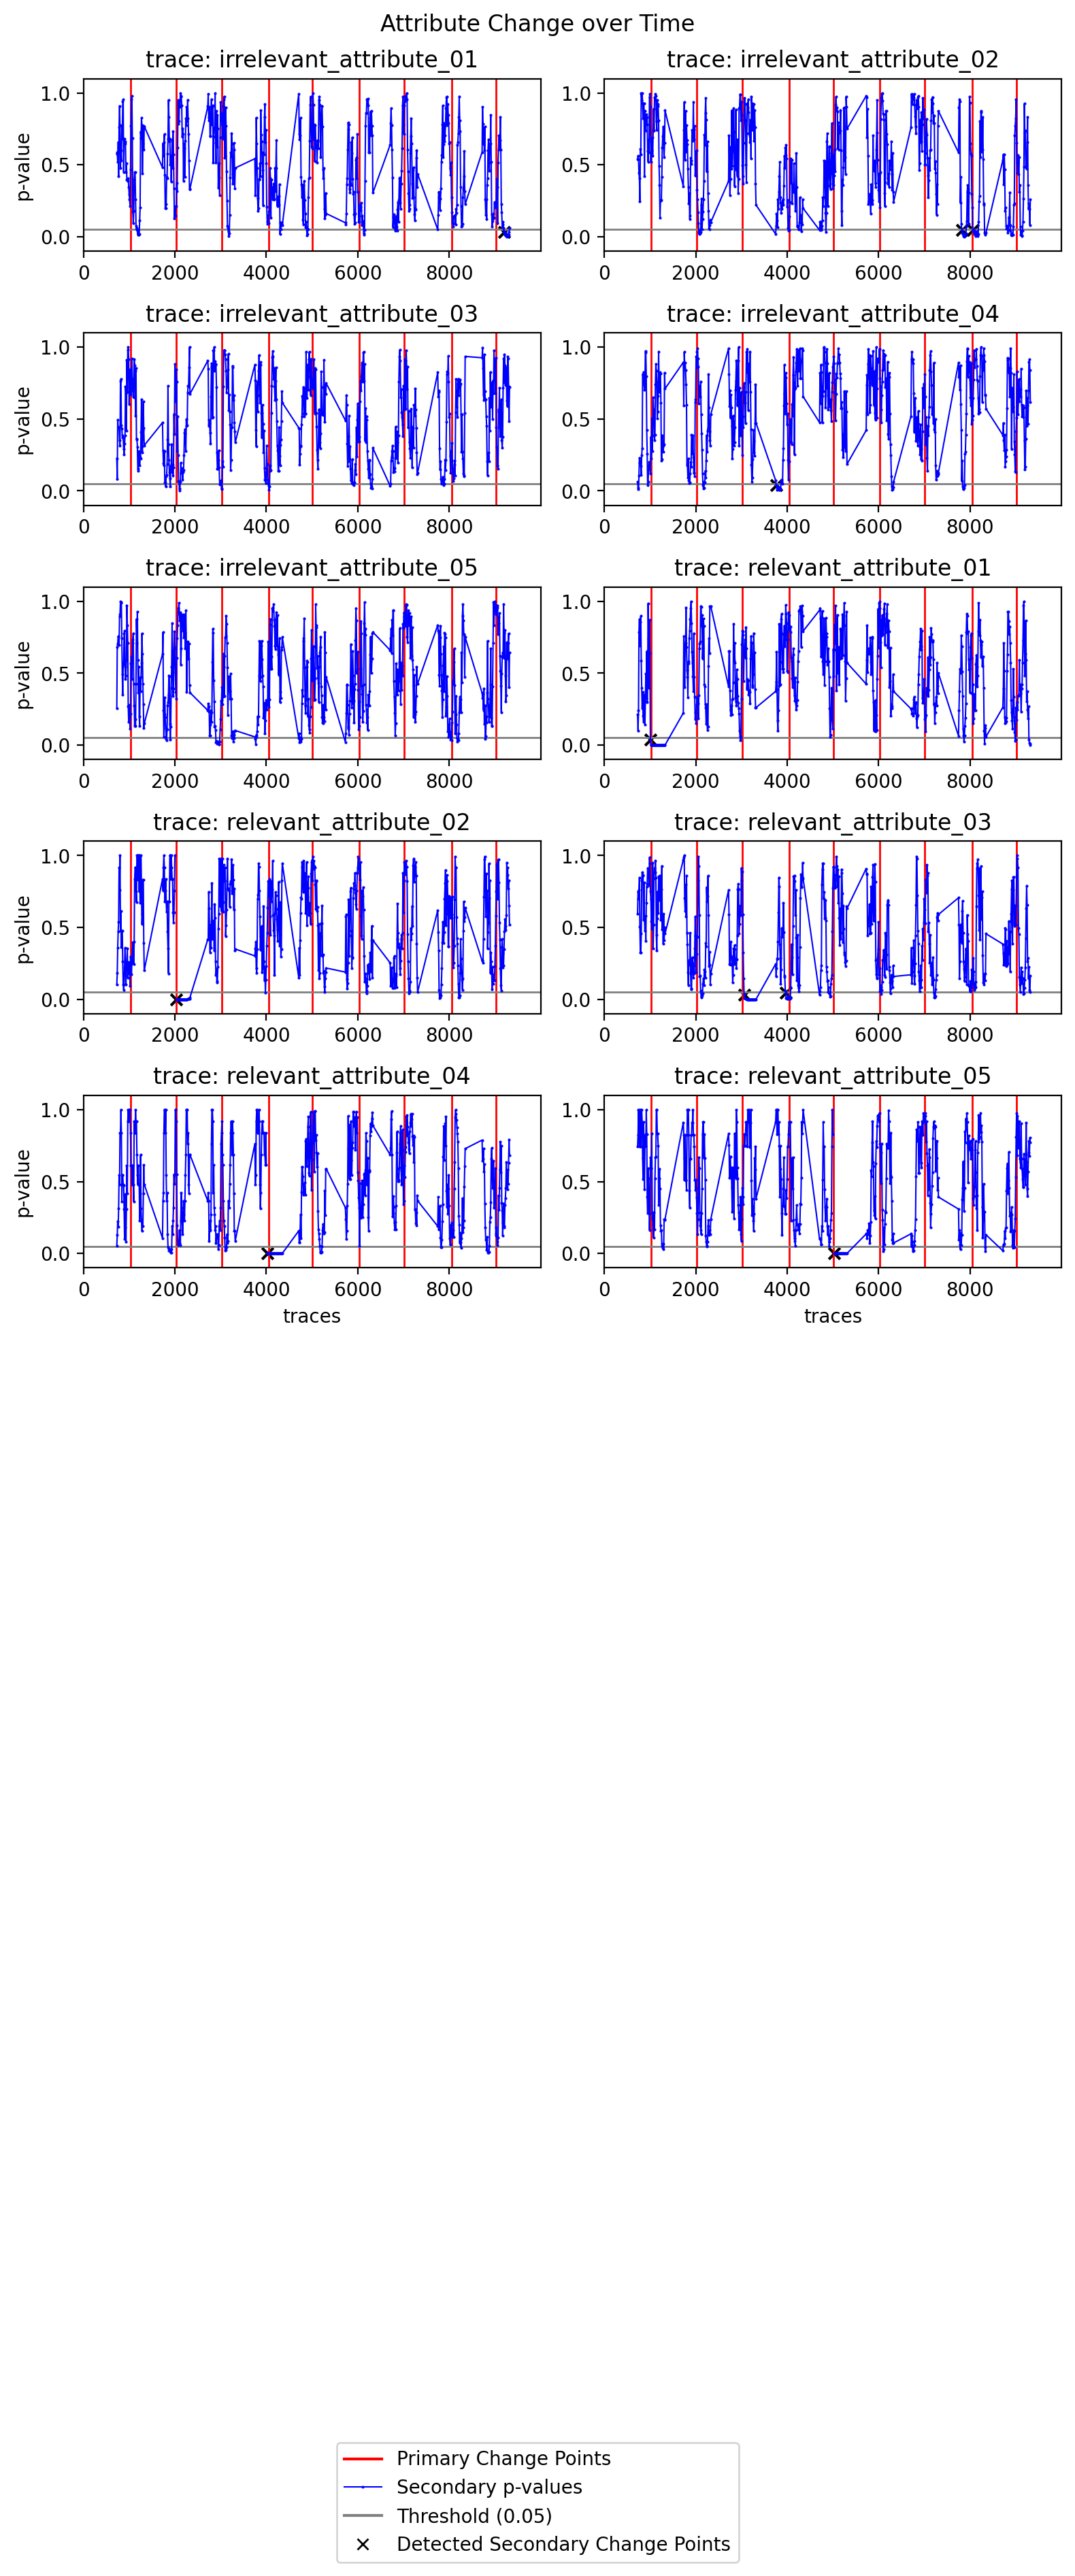

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [39]:
# plot the drift explanations
possible_drift_explanations.plot(offset_legend=-0.9)

## Perform Runtime Analysis

In [11]:
import cProfile
cProfile.run('drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)', 'profile.stats')

import pstats
p = pstats.Stats("profile.stats")
p.sort_stats(pstats.SortKey.CUMULATIVE)
p.print_stats()

NameError: name 'max_distance' is not defined

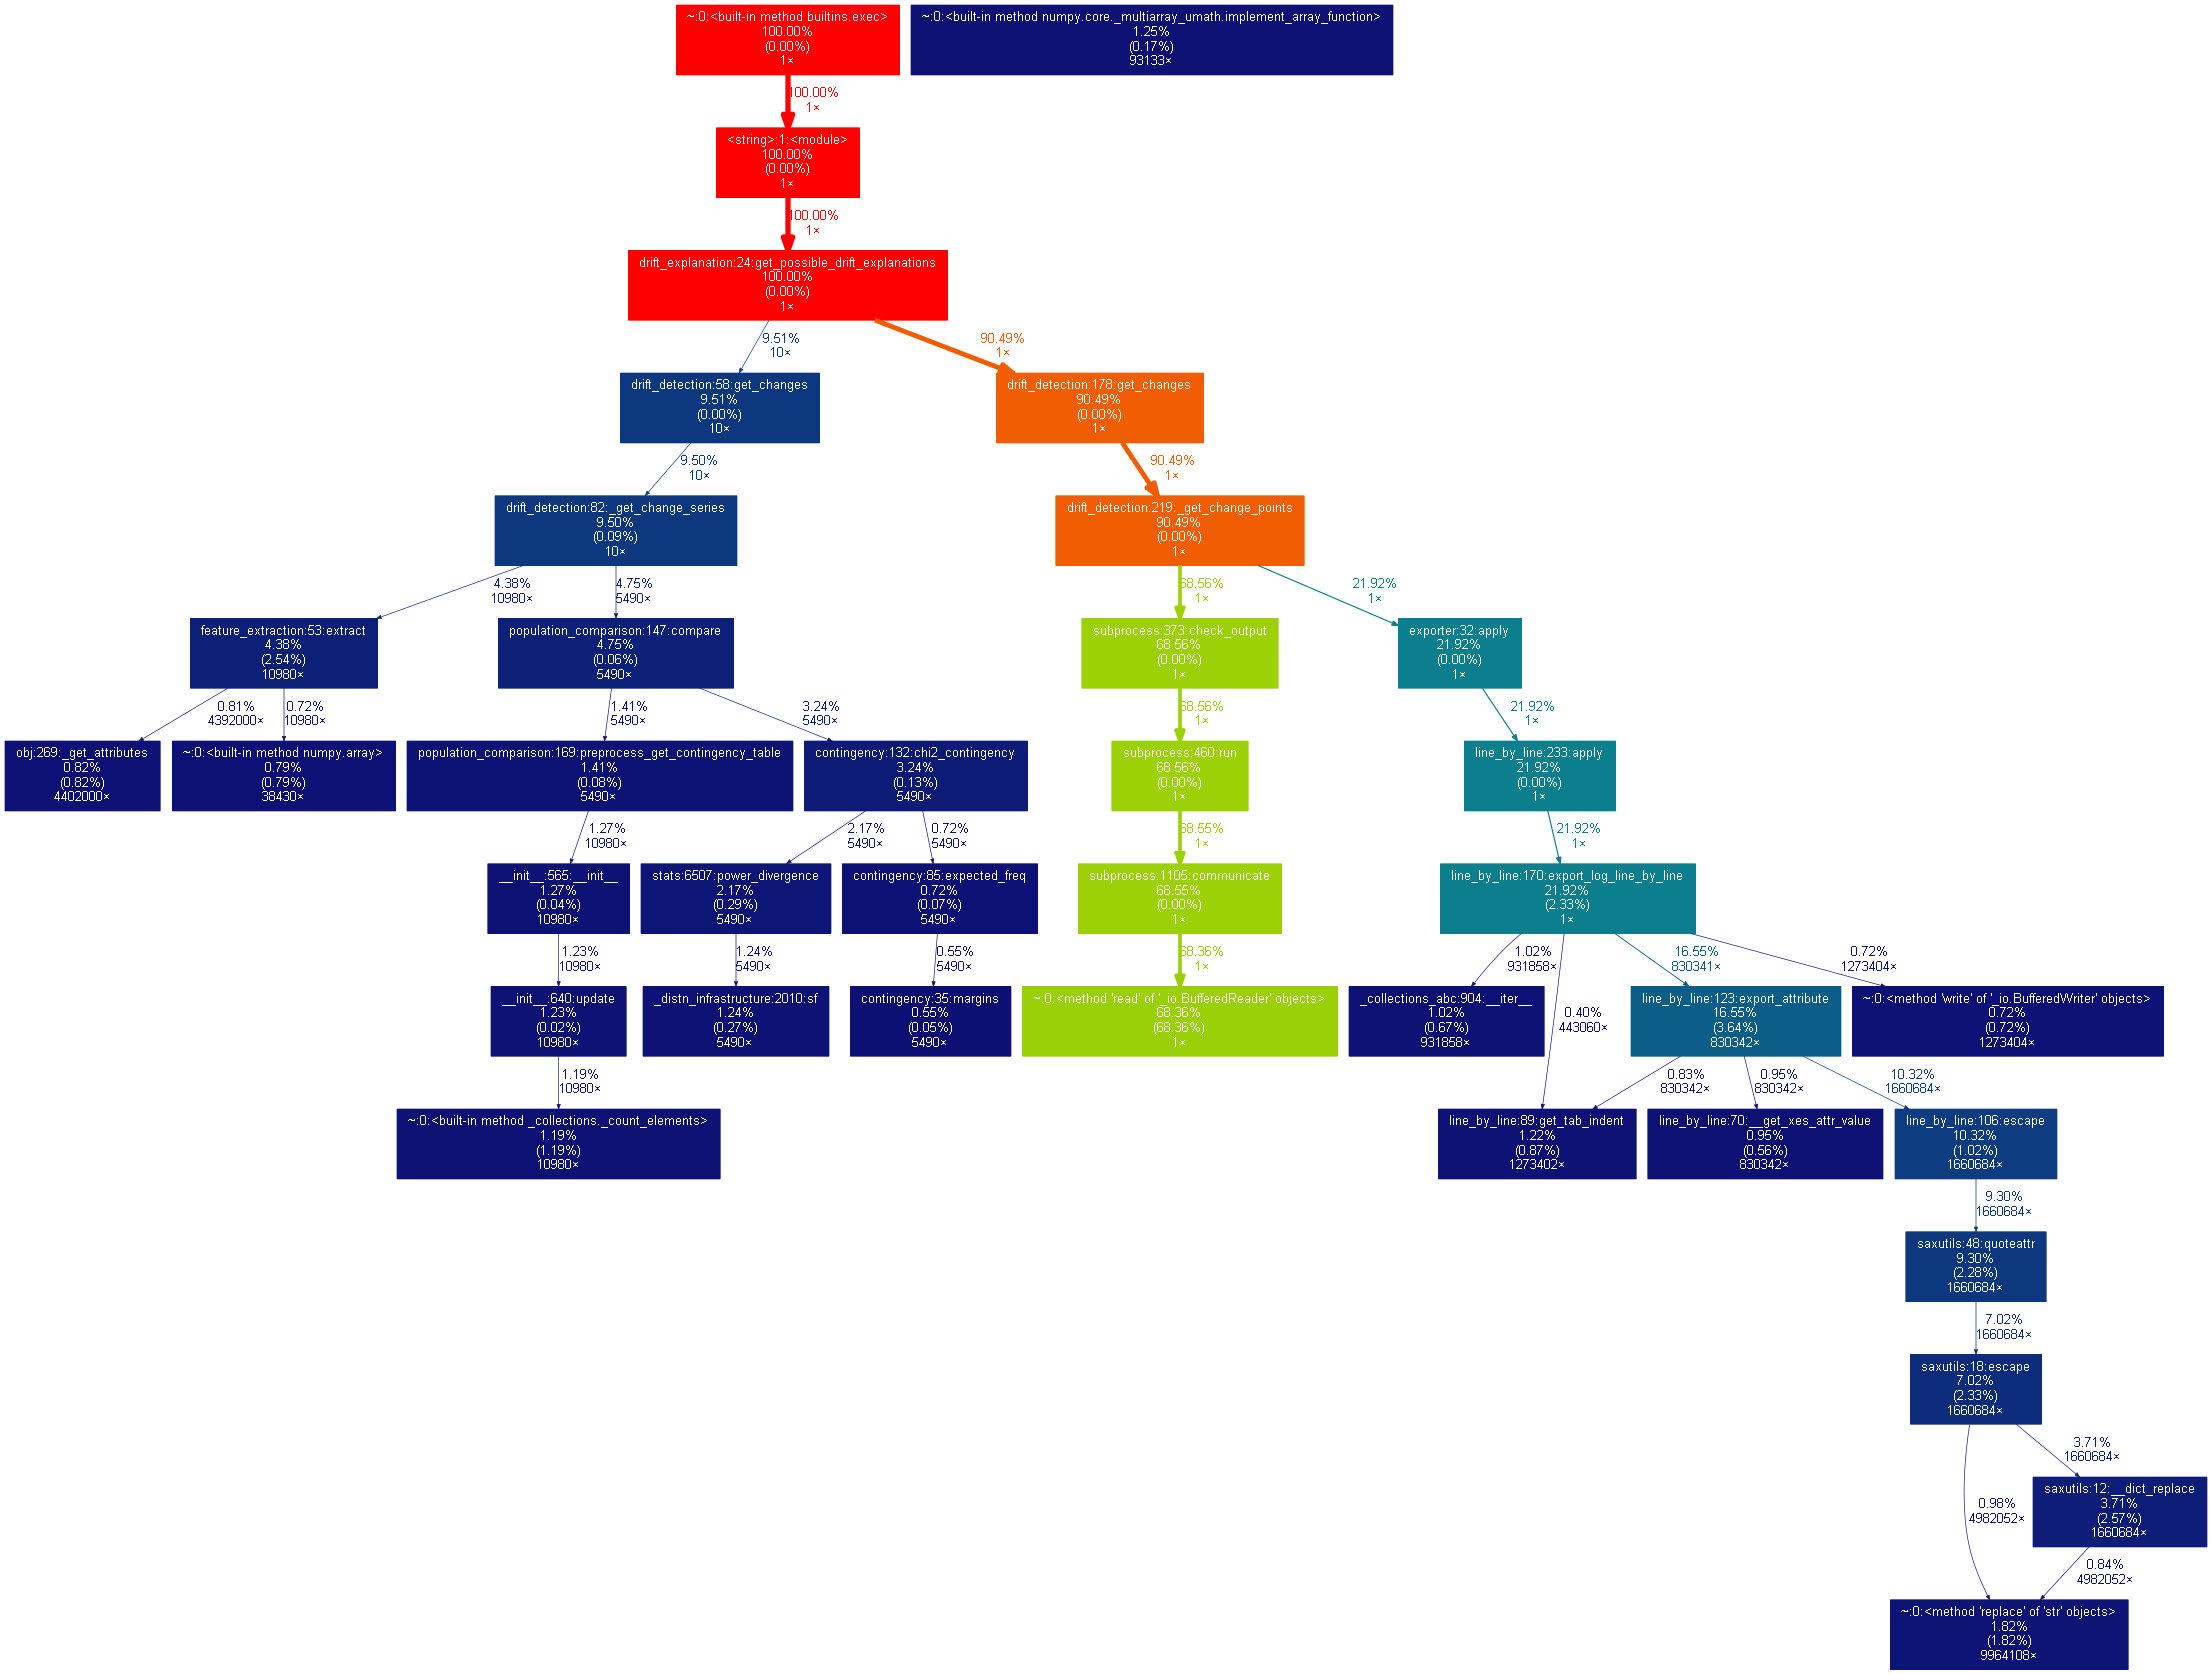

In [ ]:
!gprof2dot profile.stats -f pstats | dot -Tpng -o output.png

from IPython.display import Image
Image(filename='output.png') 